# Compare data to predictions

In the previous [notebook](https://github.com/hundredblocks/ml-powered-applications/blob/master/notebooks/train_simple_model.ipynb), we trained a simple model and looked at its accuracy, precision, recall, and f1-score. These are fine aggregate metrics, but we'd like to gain a deeper understanding of our model's performance, and its shortcomings.

In order to do that, we will start by looking at a confusion matrix, then plot an ROC curve, and finally a claibration curve.

First, we load data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.externals import joblib

import sys
sys.path.append("..")
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autoreload
%autoreload 2

from ml_editor.data_processing import (
    format_raw_df,
    get_split_by_author,
    add_text_features_to_df,
    get_vectorized_series,
    get_feature_vector_and_label,
)
from ml_editor.model_evaluation import get_confusion_matrix_plot, get_roc_plot, get_calibration_plot

data_path = Path('../data/writers.csv')
df = pd.read_csv(data_path)
df = format_raw_df(df.copy())

Then, we add features and split the dataset

In [2]:

df = add_text_features_to_df(df.loc[df["is_question"]].copy())
train_df, test_df = get_split_by_author(df, test_size=0.2, random_state=40)

We then load the trained model and vectorizer

In [3]:
model_path = Path("../models/model_1.pkl")
clf = joblib.load(model_path) 
vectorizer_path = Path("../models/vectorizer_1.pkl")
vectorizer = joblib.load(vectorizer_path) 

We use the vectorizer on our data to produce features that are ready for the model

In [4]:
train_df["vectors"] = get_vectorized_series(train_df["full_text"].copy(), vectorizer)
test_df["vectors"] = get_vectorized_series(test_df["full_text"].copy(), vectorizer)

features = [
                "action_verb_full",
                "question_mark_full",
                "text_len",
                "language_question",
            ]
X_train, y_train = get_feature_vector_and_label(train_df, features)
X_test, y_test = get_feature_vector_and_label(test_df, features)

Finally, we get the model's predictions on a held out test set

In [5]:
y_predicted = clf.predict(X_test)
y_predicted_proba = clf.predict_proba(X_test)

## Confusion matrix

First, I'll plot a confusion matrix, which gives us a clear way to view which class our model performs well on.

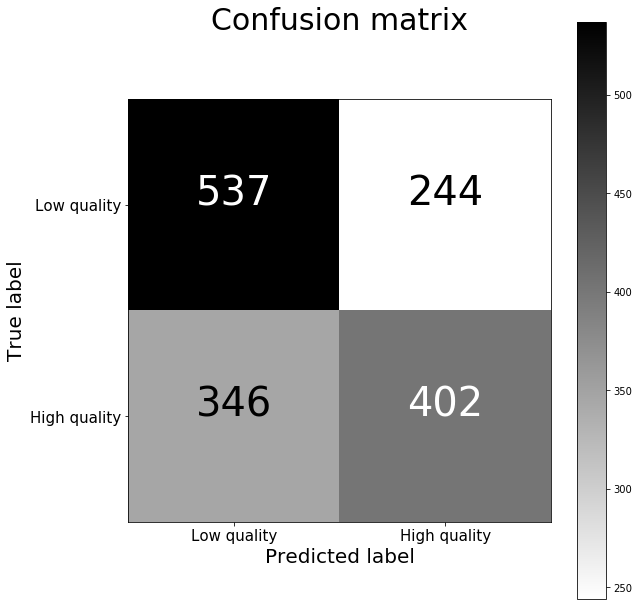

In [6]:
get_confusion_matrix_plot(y_predicted, y_test, figsize=(9, 9))
plt.show()

Looking at this confusion matrix, we can clearly see that the model seems better at predicting low score questions (it has higher recall for low score questions):

- Proportion of low score questions correctly predicted: 537/(537+244) = 68%
- Proportion of high score questions correctly predicted: 402/(402+346) = 53%

## ROC Curve

Next, I'll plot an ROC curve, which shows a model's True Positive Rate as a function of it's False Positive Rate.

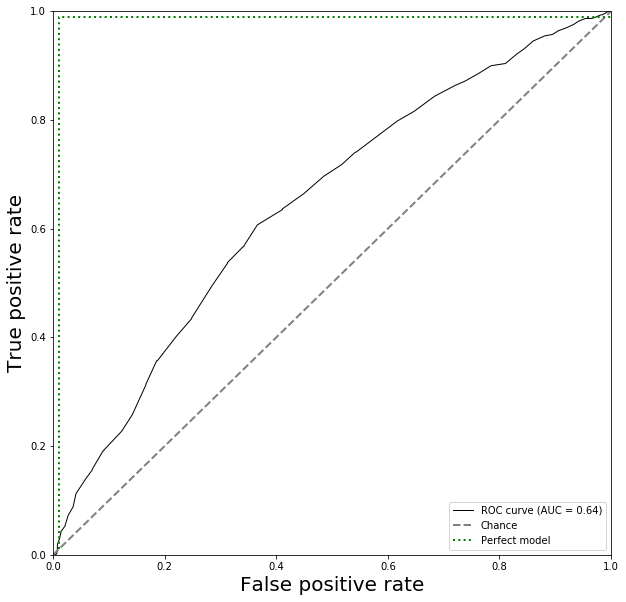

In [7]:
get_roc_plot(y_predicted_proba[:,1], y_test, figsize=(10,10))
plt.show()

ROC curves can help judge the overall performance of a model, but most models are designed with practical applications in mind. These applications often come with specific performance requirements, such as maintaining false positives below a certain rate. To understand model performance better, it can be helpful to visually highlight the relevant part of an ROC curve, as shown below.

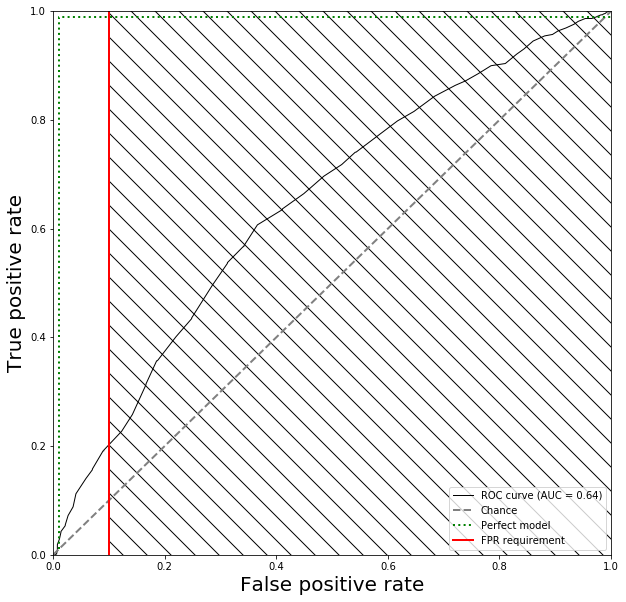

In [8]:
get_roc_plot(y_predicted_proba[:,1], y_test, fpr_bar=.1, figsize=(10,10))
plt.show()

For the chosen FPR requirement of `.1` , our model reached around `.2` true positive rate. In an application where maintaining this FPR constraint is important, this is the metric we should track in following experiments.

## Calibration curve

Finally, we'll plot a calibration curve, which plots the fraction of actual positive examples as a function of a model's probability score. Such a curve allows us to measure the quality of a model's probability estimate (when a model says a question has a `60%` chance to be good, is that actually the case?)

No handles with labels found to put in legend.


	Brier: 0.236


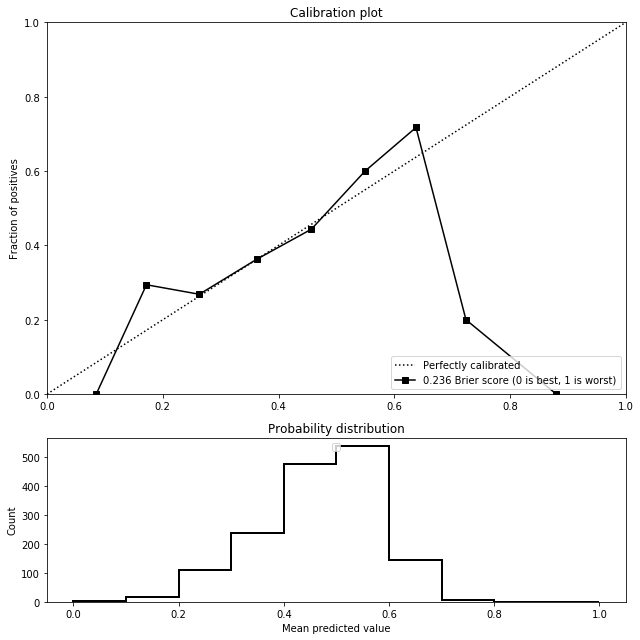

In [9]:
get_calibration_plot(y_predicted_proba[:,1], y_test, figsize=(9,9))

On this plot, we can see that the model is well calibrated between .2 and .7, and poorly outside of that. This is in part due to the fact that the model mostly outputs scores between .2 and .7 as you can see on the histogram of scores below. We also display the [Brier score](https://en.wikipedia.org/wiki/Brier_score) which is a measure of calibration ranging from 0 to 1, with a value of 0 being reached for a perfectly calibrated model.

To gain an even better understanding of success and failure modes of our model, we can examine individual examples to identify error trends (which we will do in the top-k [notebook](https://github.com/hundredblocks/ml-powered-applications/blob/master/notebooks/top_k.ipynb) ), and dig into the trained model's parameters.